# model with bleaching

To incorporate the effect of dye photobleaching in our model, we consider a transition matrix with an absorbing (bleached) state:
$$ G =
\begin{pmatrix}\Gamma & \omega \\
0 & 1
\end{pmatrix} $$
where $\Gamma$ are transitions between the transient states, $\omega$ is the vector of bleaching probabilities from each state. Note that $\Gamma$ is not row-stochastic, while $G$ is.

We model the distribution of states in the absence of bleaching using the row-stochastic matrix $\tilde{\Gamma} = \Gamma - {\rm diag}(\omega)$, corresponding to maintaining the non-diagonal transition probabilities in $\Gamma$.



In [ ]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from numpy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt

def get_equil(P):
  ev = eig(P.transpose())
  eigenvalues = ev[0]
  eigenvectors = ev[1]

  assert np.min((eigenvalues-1)**2) < 1e-7
  #print(ev.eigenvalues)
  fv = (eigenvectors[:,np.argmin((eigenvalues-1)**2)])
  nfv = fv/fv.sum()

  #check
  #print(np.matmul(nfv, P))
  return nfv

  # a simple trace class with an observed value, time, and possibly a state trajectory

class trace(object):
   def __init__(self, obs, times, states=None):
      self.obs = np.array(obs)
      self.times = np.array(times)
      if states:
        self.state = np.array(states)


   def average(self,time_resolution):

    truncate = int(time_resolution*((self.obs.shape)[0] // time_resolution))
    traj_reshaped = (self.obs[0:truncate].reshape((int(truncate/time_resolution),time_resolution)))
    times_reshaped = (self.times[0:truncate].reshape((int(truncate/time_resolution),time_resolution)))
    new_obs = traj_reshaped.mean(axis=1)
    new_times = times_reshaped.min(axis=1)

    return trace(obs=new_obs, times=new_times)



def gen_trace(P, emissions, length):
  #equil = get_equil(P)
  #nstates = len(equil)
  #state = np.random.choice(range(0,nstates), size=1, p=equil)[0]

  nstates = P.shape[0]
  state = np.random.choice(range(0,nstates-1), size=1)[0]
  states = [state]
  def emit(state):
    return np.random.normal(loc=emissions[state]['loc'], scale=emissions[state]['scale'], size=1)[0]

  obs = [emit(state)]

  for i in range(length):
    probs = np.array(P[state,:])
    state = np.random.choice(range(0,nstates),size=1, p=probs)[0]
    states.append(state)
    obs.append(emit(state))

  times = range(len(obs))
  tr = trace(obs, times, states)

  return tr


In [ ]:
N = 3
ax=.01;  bx=.005;
deatha = 0.01
deathb = 0.00

Px = np.array([
    [1-ax-deatha, ax, deatha],  # 1 to ...
    [bx, 1-bx-deathb, deathb],  # 2 to ...
    [0, 0, 1]
    ])

emissionsx = [
      {'loc':0.8,  'scale':0.1},
      {'loc':0.2 , 'scale':0.1},
      {'loc':-1, 'scale':0.00001} ]


In [ ]:
numtrc = 100
tracesx = [ gen_trace(Px, emissionsx, 500) for i in range(numtrc)]



In [ ]:
yy = []
lenyy = []
for trc in tracesx:
  if len(np.where(trc.state==2)[0])>0:
    obs = trc.obs[0:(np.min(np.where(trc.state==2)[0])+1)]
  else:
    obs = trc.obs
  yy.append(obs)
  lenyy.append(len(obs))

yyall = np.concatenate(yy)


In [ ]:
np.mean(lenyy)

254.35

In [ ]:

w_johnathan = np.concatenate([np.repeat(1/ll,ll) for ll in lenyy])

In [ ]:
def get_transientP(Q):
  P = Q[:,:-1][:-1,:] + np.diag(Px[:,-1][:-1])
  deathp = Q[:,-1]
  return P

def get_quasiequil(Q):
  P = get_transientP(Q)
  return get_equil(P)


get_quasiequil(Px)
traces_quasi = [ gen_trace(get_transientP(Px), emissionsx[:-1], 500) for i in range(numtrc)]
traces_quasiall = np.concatenate([tr.obs for tr in traces_quasi])


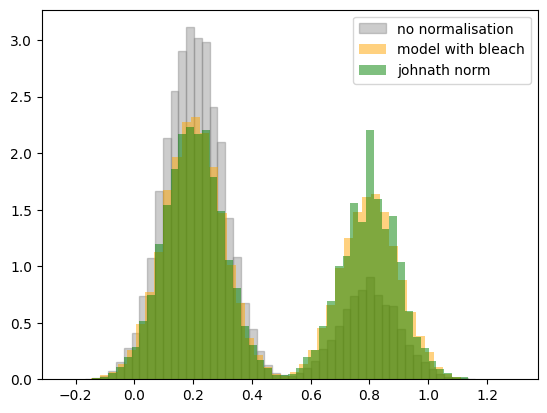

In [ ]:
_ = plt.hist(yyall[yyall>-0.5], bins=50, label='no normalisation',alpha=0.4,density=True,
             edgecolor="gray", color='gray'
             )
_ = plt.hist(traces_quasiall, bins=50, label='model with bleach',
             color='orange',
             alpha=0.5,density=True)
_ = plt.hist(yyall[yyall>-0.5], weights=w_johnathan[yyall>-0.5],
             bins=50, label='johnath norm',alpha=0.5,density=True, color='green')
plt.legend()
